<a href="https://colab.research.google.com/github/Fondzenyuy/Google-Collab/blob/main/Updated_Trial_Simple_Machine_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source: EdX Lecture Material - Dropout

# Loading Data 

In [ ]:
# Import the libraries we need for the lab
import sys, os, time
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0) 

In [ ]:
# Create Data object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES= 200, noise_std=1, train=True):
        self.len = 200
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = (self.x)*torch.sin(20*self.x) - ((self.x)**2)*torch.cos(10*self.x)  #key function in model for outputs
        if train != True:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
        else:
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot(self):
        plt.figure(figsize = (6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy() ,label="True Function", color='Green')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

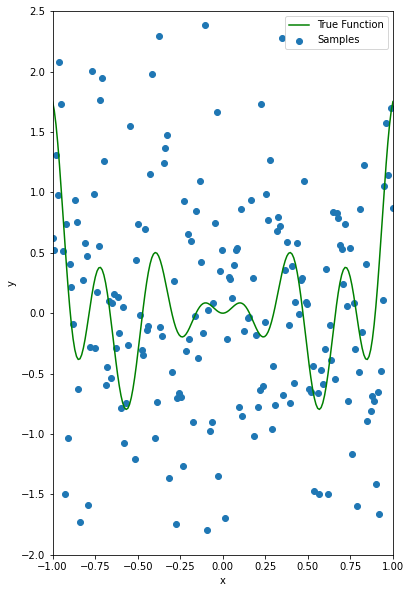

In [ ]:
#plot the created dataset(Model has been passed on as the output for the process)

data_set = Data()
data_set.plot()

# Before Training : Avant la formation

In [ ]:
# Create validation dataset object (prior to training)

validation_set = Data(train=False)

In [ ]:
# Create the class for model

class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        
    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

In [ ]:
# Create the model objects

model = Net(1, 250, 1)
model_drop = Net(1, 250, 1, p=0.5)

In [ ]:
# Set the model to train mode

model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=250, bias=True)
  (linear3): Linear(in_features=250, out_features=1, bias=True)
)

In [ ]:
# Set the optimizer and criterion function

optimizer_ofit = torch.optim.Adam(model.parameters(), lr= 1e-3)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr= 1e-3)
criterion = torch.nn.MSELoss()

In [ ]:
# Initialize the dict to contain the loss results for model

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

# Train Model (with batch gradient step) WORKED

In [ ]:
# Train the model

epochs = 5500
train_loader = DataLoader(data_set, shuffle= True, batch_size = 64)

def train_model(epochs):
    for epoch in range(epochs):
      for i, (x, y) in enumerate(train_loader):
        model.train()
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for  both the training and validation  data for both models 
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()
        
train_model(epochs)

In [ ]:
#Set the model with dropout to evaluation mode

model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=250, bias=True)
  (linear3): Linear(in_features=250, out_features=1, bias=True)
)

In [ ]:
# Make the prediction

yhat = model(data_set.x)
yhat_drop = model_drop(data_set.x)

# Analysis

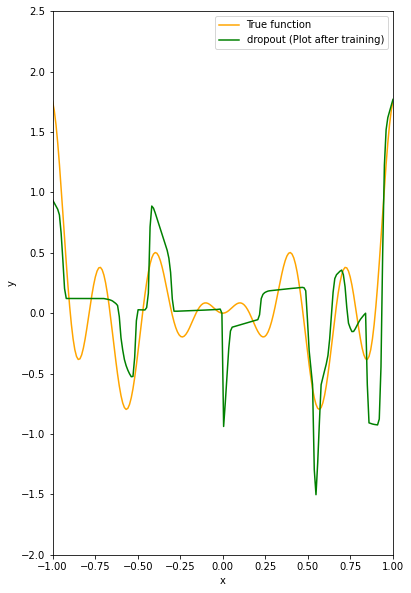

In [ ]:
# Plot the predictions for both models

plt.figure(figsize=(6.1, 10))

#plt.scatter(data_set.x.numpy(), data_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy(), label="True function", color='orange')
#plt.plot(data_set.x.numpy(), yhat.detach().numpy(), label='no dropout', c='r')
plt.plot(data_set.x.numpy(), yhat_drop.detach().numpy(), label="dropout (Plot after training)", c ='g')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

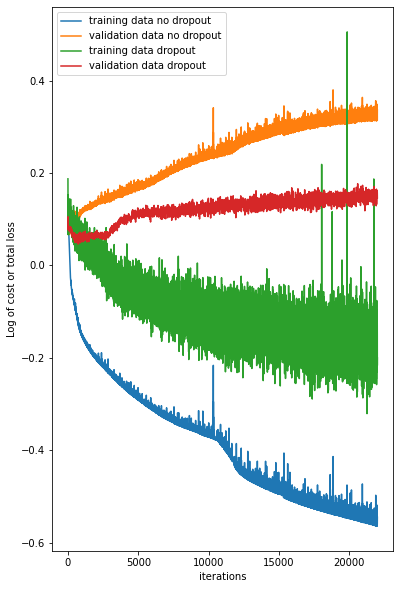

In [ ]:

# Plot the loss

plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")